In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import sys
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from huggingface_hub import snapshot_download
sys.path.append('/Users/charl/OneDrive/Documents/__water/floOoo/code/py/')
import floOoo_neurofusion_functions as flo

In [2]:
plt.style.use(plt.style.available[0])

In [3]:
def reload_functions():
    import importlib
    import floOoo_neurofusion_functions as flo
    importlib.reload(flo)
    

In [4]:
# load defaults
rootDir = '/Users/charl/OneDrive/Documents/__water/floOoo/code/data/neurofusion/eeg-restingstate/'
sample_rate, channels, analysisDir_temp = flo.load_defaults() # fix - move this within class
nChannels = len(channels)

chColors = {}
for channel, color in zip(sorted(channels), sns.color_palette('Set1', nChannels)):
    chColors[channel] = color
    
events = flo.load_events(rootDir)

In [5]:
reload_functions()
folder, filenames = flo.get_filenames(rootDir)

In [6]:
filenames

['rawBrainwaves_1674239692.csv',
 'rawBrainwaves_1674322176.csv',
 'rawBrainwaves_1674325610.csv',
 'rawBrainwaves_1674454790.csv',
 'rawBrainwaves_1674495760.csv',
 'rawBrainwaves_1674520142.csv',
 'rawBrainwaves_1674539317.csv',
 'rawBrainwaves_1674569354.csv',
 'rawBrainwaves_1674613052.csv',
 'rawBrainwaves_1674630344.csv',
 'rawBrainwaves_1674719194.csv',
 'rawBrainwaves_1674748330.csv',
 'rawBrainwaves_1674750807.csv',
 'rawBrainwaves_1674791018.csv',
 'rawBrainwaves_1674886663.csv',
 'rawBrainwaves_1674916543.csv',
 'rawBrainwaves_1674926222.csv',
 'rawBrainwaves_1674959009.csv',
 'rawBrainwaves_1674966879.csv',
 'rawBrainwaves_1675001725.csv',
 'rawBrainwaves_1675006569.csv',
 'rawBrainwaves_1675029843.csv',
 'rawBrainwaves_1675044968.csv',
 'rawBrainwaves_1675054666.csv',
 'rawBrainwaves_1675099686.csv',
 'rawBrainwaves_1675120167.csv',
 'rawBrainwaves_1675142192.csv',
 'rawBrainwaves_1675187274.csv']

In [7]:
# fix - move this to cleaning
def get_maxSDs(chData):
    maxSDs = np.abs(stats.zscore(chData, axis=1)).max(axis=0)
    return maxSDs

In [14]:
filename = filenames[3]

data = flo.Filename_RawBrainwave(folder, filename)
channels = data.channels
chData = data.load_chData()


In [10]:
obs = []
obsInfo = {'fileID' : [], 'channel' : [], 'timeofday' : []}
for filename in filenames:
    fileID = int(filename.split('_')[1].split('.')[0])
    chData = load_chData(folder, filename)

    match = np.flatnonzero(events['startTimestamp'] == fileID)
    if len(match) == 1:
        timeofday = events.iloc[match[0]]['timeofday']
    else:
        print(len(match))
        timeofday = np.nan

    #chData = stats.zscore(chData, axis=1)
    for channel, eeg in zip(channels, chData):
        freqAx, psd = flo.get_psd(eeg, sample_rate)
        obs.append(psd)
        obsInfo['fileID'].append(fileID)
        obsInfo['channel'].append(channel)
        obsInfo['timeofday'].append(timeofday)
        
obs = np.row_stack(obs)
obsInfo = pd.DataFrame(obsInfo)
obsInfo['fileID'] = obsInfo['fileID'].astype(int)

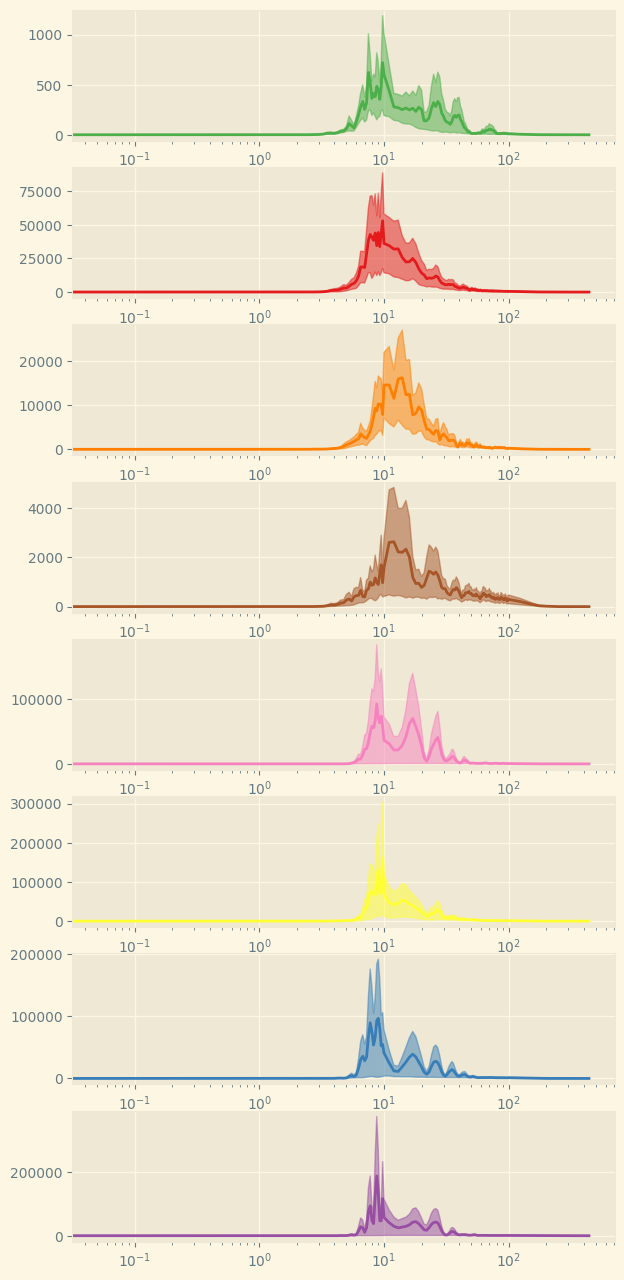

In [13]:
reload_functions()
plt.figure(figsize=(7, 2*nChannels))
for chi, channel in enumerate(channels):
    color = chColors[channel]
    plt.subplot(nChannels, 1, chi+1)
    inds = np.flatnonzero(obsInfo['channel'] == channel)
    m, se = flo.get_nanMSE4obs(obs[inds])
    plt.plot(freqAx, m, color=color, lw=2)
    plt.fill_between(freqAx, m-se, m+se, color=color, alpha=0.5)
    plt.xscale('log')

In [14]:
timeofdays = [s for s in np.unique(events['timeofday']) if 'afternoon' not in s]



def get_obs_4_channel(channel):
    obs_ = []
    obsInfo_ = []
    
    for timeofday in timeofdays:
        for fileID in events.iloc[np.flatnonzero(events['timeofday'] == timeofday)]['startTimestamp']:
            match = np.intersect1d(np.flatnonzero(obsInfo['fileID'] == fileID), np.flatnonzero(obsInfo['channel'] == channel))
            if len(match) == 1:
                i = match[0]
                obs_.append(obs[i, :])
                obsInfo_.append(obsInfo.iloc[i])
                
    obsInfo_ = pd.DataFrame(obsInfo_)
    obs_ = np.row_stack(obs_)
    
    return obs_, obsInfo_





In [15]:

w_lda, w_psd = 7, 5
wTot = w_lda + w_psd
h = 4
hTot = nChannels * h

facecolor = None

plt.figure(figsize=(wTot, hTot))
grid = plt.GridSpec(hTot, wTot, hspace=3.5, wspace=0.5)

reload_functions()

currH = 0
for channel in channels:

    timeofday_colors = {'morning' : 'gray', 'evening' : chColors[channel]}
    
    currW = 0
    obs_, obsInfo_ = get_obs_4_channel(channel)
    
    lda = LDA()
    lda.fit(obs_, obsInfo_['timeofday']) 
    
    plt.subplot(grid[currH:(currH+h), currW:(currW+w_lda)], facecolor=facecolor)
    flo.plot_title(channel, color=chColors[channel], fontsize=16)
    
    obProj_ = np.array([np.dot(lda.coef_, ob) for ob in obs_]) 
    rdmY = np.array([np.random.random() for _ in obProj_])
    
    for timeofday in timeofdays:
        inds = np.flatnonzero(obsInfo_['timeofday'] == timeofday)
        plt.plot(obProj_[inds], rdmY[inds], 'o', color=timeofday_colors[timeofday], label=timeofday)
        plt.ylim(-3, 3)
    plt.legend()
    plt.xlabel('Projection (a.u.))')
    currW += w_lda

    plt.subplot(grid[currH:(currH+h), currW:(currW+w_lda)], facecolor=facecolor)
    lw = 2
    for timeofday in timeofdays:
        color = timeofday_colors[timeofday]
        inds = np.flatnonzero(obsInfo_['timeofday'] == timeofday)
        m, se = flo.get_nanMSE4obs(obs_[inds, :])
        plt.plot(freqAx, m, color=color, lw=lw)
        plt.fill_between(freqAx, m-se, m+se, color=color, alpha=0.5)
    plt.ylabel('Power ()', color=timeofday_colors['evening'])
    plt.xscale('log')
    plt.yscale('log')
    ax2 = plt.twinx()
    yMax = np.abs(lda.coef_[0]).max()*1.8
    ax2.plot(freqAx, lda.coef_[0], color='k')
    ax2.set_ylim(-yMax, yMax)
    ax2.set_ylabel('Coef.')

    currH += h
    
    
flo.save_image('jj_spec_LDA_timeofday')

## 

In [22]:
pca = PCA(n_components=9)
pca.fit(obs.T)

PCA(n_components=9)

In [27]:

#plt.plot(pca.components_[0, :], pca.components_[1, :], 'o')

In [36]:


#pca.components_[0, inds]

emb = TSNE(n_components=2, perplexity=30, early_exaggeration=5, learning_rate=10, n_iter=1000).fit_transform(pca.components_.T)


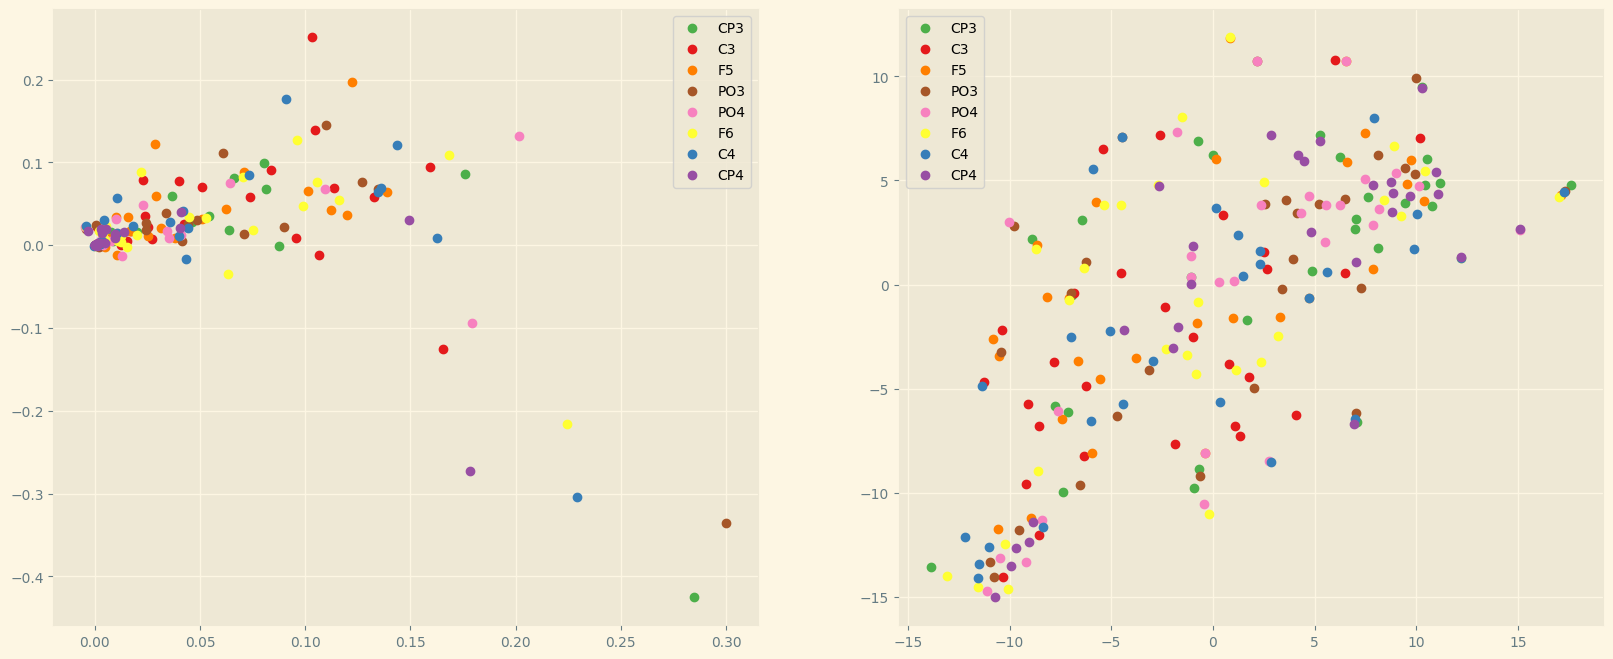

In [40]:
titles = ['PCA', 'PCA-TSNE']
n2plot = len(titles)
plt.figure(figsize=(20, 8))
for ploti, title in enumerate(titles):
    plt.subplot(1, n2plot, ploti+1)
    if title == 'PCA':
        emb_ = pca.components_.T
    else:
        emb_ = emb
    for channel in channels:
        inds = np.flatnonzero(obsInfo['channel'] == channel)
        plt.plot(emb_[inds, 0], emb_[inds, 1], 'o', color=chColors[channel], label=channel)
    plt.legend()

In [50]:
fileIDs = sorted(np.unique(obsInfo['fileID']))
fileID_colors = {}
for fileID, color in zip(fileIDs, sns.color_palette('GnBu_r', len(fileIDs))):
    fileID_colors[fileID] = color


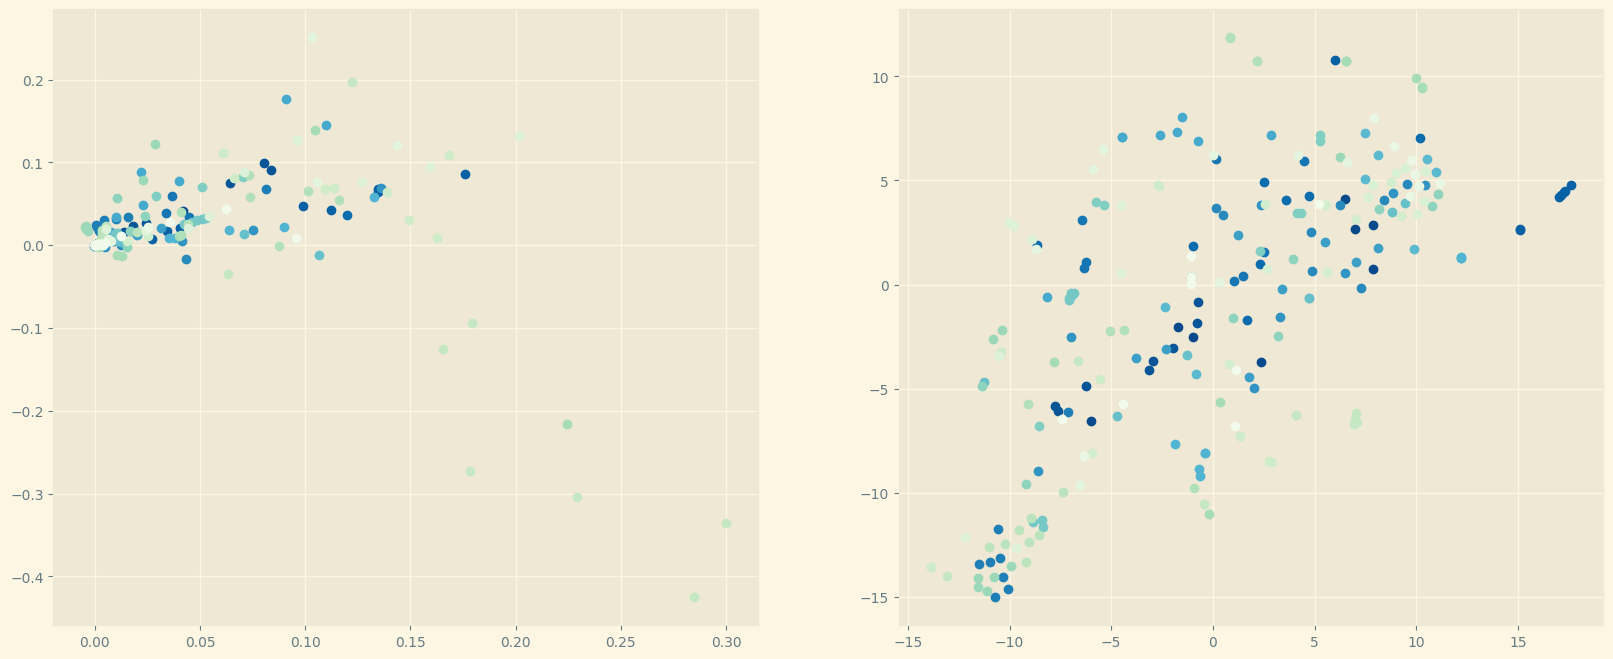

In [51]:
titles = ['PCA', 'PCA-TSNE']
n2plot = len(titles)
plt.figure(figsize=(20, 8))
for ploti, title in enumerate(titles):
    plt.subplot(1, n2plot, ploti+1)
    if title == 'PCA':
        emb_ = pca.components_.T
    else:
        emb_ = emb
    #for channel in channels:
    for fileID in fileIDs:
        inds = np.flatnonzero(obsInfo['fileID'] == fileID)
        plt.plot(emb_[inds, 0], emb_[inds, 1], 'o', color=fileID_colors[fileID], label=fileID)
    #plt.legend()

In [42]:
obsInfo['fileID']

0      1674239692.csv
1      1674239692.csv
2      1674239692.csv
3      1674239692.csv
4      1674239692.csv
            ...      
219    1675187274.csv
220    1675187274.csv
221    1675187274.csv
222    1675187274.csv
223    1675187274.csv
Name: fileID, Length: 224, dtype: object

# Class play

In [134]:
def load_chData(folder, filename):
        data = pd.read_csv(folder+filename)
        chData = np.row_stack([data[channel] for channel in channels])
        return chData

def get_maxSDs(chData):
    maxSDs = np.abs(stats.zscore(chData, axis=1)).max(axis=0)
    return maxSDs
    

# Data cleaning

In [125]:
zThresh = 20
color_zThresh = 'r'
nHistBins = 100


nFiles = len(filenames)

w_trace, w_hist = 18, 6
h = 5
facecolor = None
wTot = w_trace + w_hist
hTot = h * nFiles


plt.figure(figsize=(wTot, hTot))
grid = plt.GridSpec(hTot, wTot, hspace=1.5, wspace=0.5)



currH = 0
plt.figure(figsize=(20, nFiles*5))
for fi, filename in enumerate(filenames):
    currW = 0
    plt.subplot(grid[currH:(currH+h), currW:(currW+w_trace)], facecolor=facecolor)
    plt.yticks(fontsize=14)
    flo.plot_title(filename.split('_')[1])

    # fix - class
    chData = load_chData(folder, filename)
    maxSDs = get_max_SDs(chData)

    
    plt.plot(maxSDs)
    plt.hlines(zThresh, 0, len(maxSDs), linestyles='--', color=color_zThresh, lw=2, alpha=0.5)
    currW += w_trace

    plt.subplot(grid[currH:(currH+h), currW:(currW+w_hist)], facecolor=facecolor)

    edges = np.linspace(0, np.ceil(maxSDs.max()), nHistBins+1)
    cens, counts, _ = flo.get_hist(maxSDs, edges, norm=True)
    x, y = flo.get_xy_4_histFill(cens, counts)
    plt.plot(x, y)
    plt.fill_between(x, np.zeros_like(x), y, alpha=0.4)
    plt.vlines(zThresh, 0, counts.max(), linestyles='--', color=color_zThresh, lw=2, alpha=0.5)
    plt.yscale('log')
    
    currH += h
    
flo.save_image('jjmaxSDs')


<Figure size 2400x14000 with 0 Axes>

In [142]:
# explore higher zscores

In [127]:
filename = filenames[0]

In [135]:
chData = load_chData(folder, filename)
maxSDs = get_maxSDs(chData)

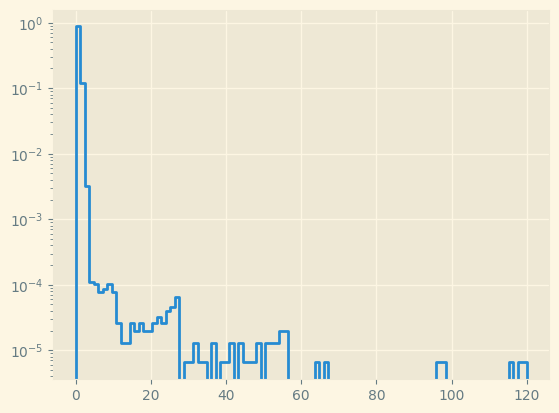

In [141]:
edges = np.linspace(0, np.ceil(maxSDs.max()), nHistBins+1)
cens, counts, _ = flo.get_hist(maxSDs, edges, norm=True)
x, y = flo.get_xy_4_histFill(cens, counts)
plt.plot(x, y)
plt.yscale('log')

In [162]:
zThreshs = np.linspace(0, np.ceil(maxSDs.max()), nHistBins+1)


y = []

for zThresh in zThreshs:
    bouts = flo.get_boutWindows(maxSDs < zThresh)
    if not len(bouts):
        y.append(np.nan)
    else:
        y.append(np.median(np.subtract(bouts[:, 1], bouts[:, 0]))/sample_rate)
y = np.array(y)

#maxSDs, zThresh

IndexError: list index out of range

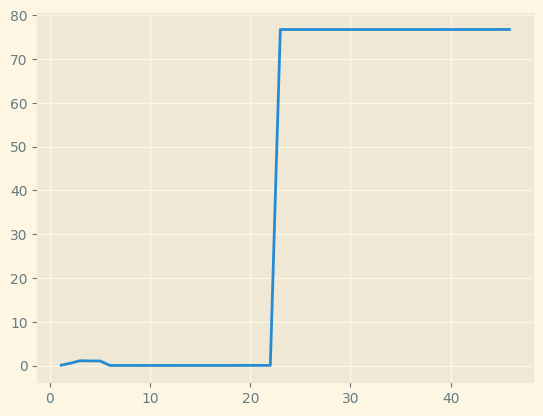

In [163]:
plt.plot(y)

In [122]:
os.chdir(analysisDir_temp)

In [123]:
reload_functions()

C:\Users\charl\AppData\Local\Temp\ipykernel_22104\1567541902.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [77]:
reload_functions()

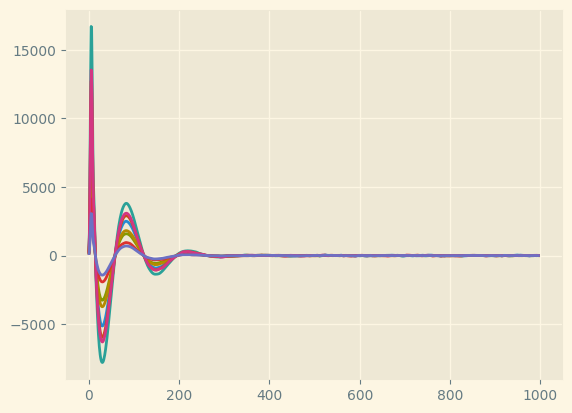

In [59]:
for channel in channels:
    plt.plot(chData[channel][:1000])

In [ ]:
chData[channel]

In [164]:
window = [20, 40]
maxSDs, wind

array([ 2.40995905, 11.50231432, 32.96988586, ...,  0.54520932,
        0.80909594,  0.95817265])

In [12]:
repo_id = 'neurofusion/eeg-restingstate'
repo_type = 'dataset'

In [10]:
download = False
if download:
    os.chdir(rootDir)
    snapshot_download(repo_id, repo_type=repo_type, cache_dir=rootDir, local_dir_use_symlinks=True)
    #snapshot_download('neurofusion/eeg-restingstate', repo_type='dataset', allow_patterns='*csv')


In [13]:
repo_a, repo_b = repo_id.split('/')
repoStr = repo_type+'s'+'--'+repo_a+'--'+repo_b

In [14]:
from datasets import load_dataset

In [21]:
data = load_dataset(repo_id)
#data = load_dataset(repo_id, allow_patterns='*rawBrainwaves*')


Resolving data files:   0%|          | 0/153 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationCastError: An error occurred while generating the dataset

All the data files must have the same columns, but at some point there are 41 new columns (CP3_alpha, PO3_gamma, F6_gamma, C4_alpha, C3_alpha, CP4_beta, CP4_delta, F5_alpha, PO3_theta, F6_theta, C4_gamma, C3_beta, PO4_delta, F5_gamma, C4_delta, F5_delta, CP4_gamma, PO4_beta, CP3_theta, CP3_beta, F6_beta, CP3_delta, PO3_delta, C3_gamma, CP3_gamma, PO4_theta, unixTimestamp, F6_alpha, PO3_alpha, PO3_beta, PO4_alpha, PO4_gamma, C4_beta, F5_beta, C3_delta, C3_theta, F6_delta, C4_theta, CP4_alpha, F5_theta, CP4_theta) and 4 missing columns (metric, probability, timestamp, label).

This happened while the json dataset builder was generating data using

hf://datasets/neurofusion/eeg-restingstate/powerByBand/powerByBand_1674239692.json (at revision fe43ac768e0e0df525c5925edb9c27c186730b3b)

Please either edit the data files to have matching columns, or separate them into different configurations (see docs at https://hf.co/docs/hub/datasets-manual-configuration#multiple-configurations)

In [16]:
data

NameError: name 'data' is not defined

In [19]:
data = load_dataset('gretelai/synthetic_text_to_sql')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [20]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 5851
    })
})

In [98]:
reload_functions()


In [91]:
x = data[channel]

In [99]:
freqAx, psd = flo.get_psd(x, sample_rate) 

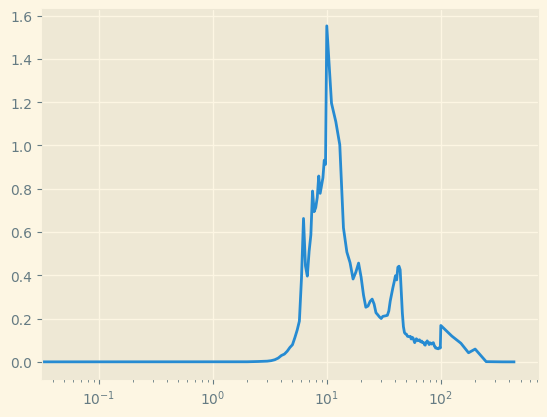

In [101]:
plt.plot(freqAx, psd)
plt.xscale('log')

In [25]:
filename = os.listdir(rootDir)[0]
path = rootDir+filename

In [34]:
path

'/Users/charl/OneDrive/Documents/__water/floOoo/code/data/focus_focus_1674239692.json'

In [146]:
path

'/Users/charl/OneDrive/Documents/__water/floOoo/code/data/rawBrainwaves_rawBrainwaves_1674239692.csv'

In [147]:
with open(path, 'r') as f:
    data = json.load(f)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [45]:
ks = list(data[0].keys())
kData = {}
for k in ks:
    kData[k] = [datai[k] for datai in data] 

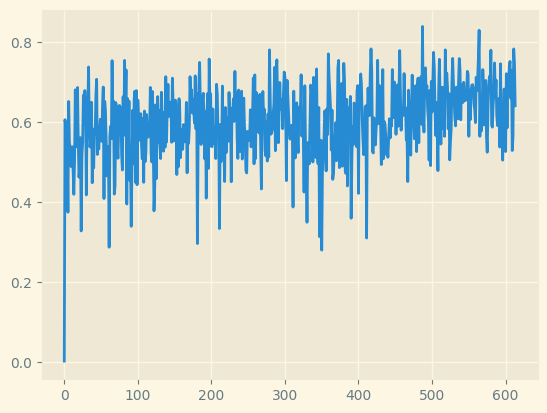

In [56]:
ks
['label', 'metric', 'probability', 'timestamp'][1]

plt.plot(kData['probability'])


In [66]:
filenames = [filename for filename in os.listdir(rootDir) if 'rawBrainwaves' in filename]
filename = filenames[0]

path = rootDir+filename
path

'/Users/charl/OneDrive/Documents/__water/floOoo/code/data/rawBrainwaves_rawBrainwaves_1674239692.csv'

In [67]:
data = pd.read_csv(path)

In [70]:
data.shape

(153488, 10)

In [73]:
data.keys()

Index(['Unnamed: 0', 'unixTimestamp', 'CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6',
       'C4', 'CP4'],
      dtype='object')